In [550]:
#Codigo para el analisis del modelo Toggle-Switch propuesto por Gardner (2000).
from functools import partial 
from collections import defaultdict 
import numpy as np 
import matplotlib.pyplot as plt
import scipy.integrate 
from mpl_toolkits.mplot3d import axes3d #Grafica la birucacion en 3D
import matplotlib.patches as mpatches 
import sympy
%matplotlib inline

In [551]:
# Parametros
escenarios = [{'alpha':1.2781, 'beta':1.9793}, 
             {'alpha':1.0028, 'beta':15}] #Escenarios de la dinamica del modelo

# TimeSpan
tiempo = np.linspace(0, 20, 1000)

# Condiciones iniciales
init_cond = [(.1,1), (2,2),(1,1.3),(2,3),(2,1),(1,2)]

In [552]:
def switch_celular(y, t, alpha, beta):
    u, v = y 
    return np.array([(alpha/(1+v**beta)) - u ,
                     (alpha/(1+u**beta)) - v])
# Este comando nos permite hacer el analisis numerico del modelo de Gardner 

In [553]:
# Definimos las trayectorias tomando a f como parcial
trayectoria = {}
for i,param in enumerate(escenarios):
    for j,ic in enumerate(init_cond):
        trayectoria[i,j] = scipy.integrate.odeint(partial(switch_celular, **param),
                                                 y0=ic,
                                                 t=tiempo)

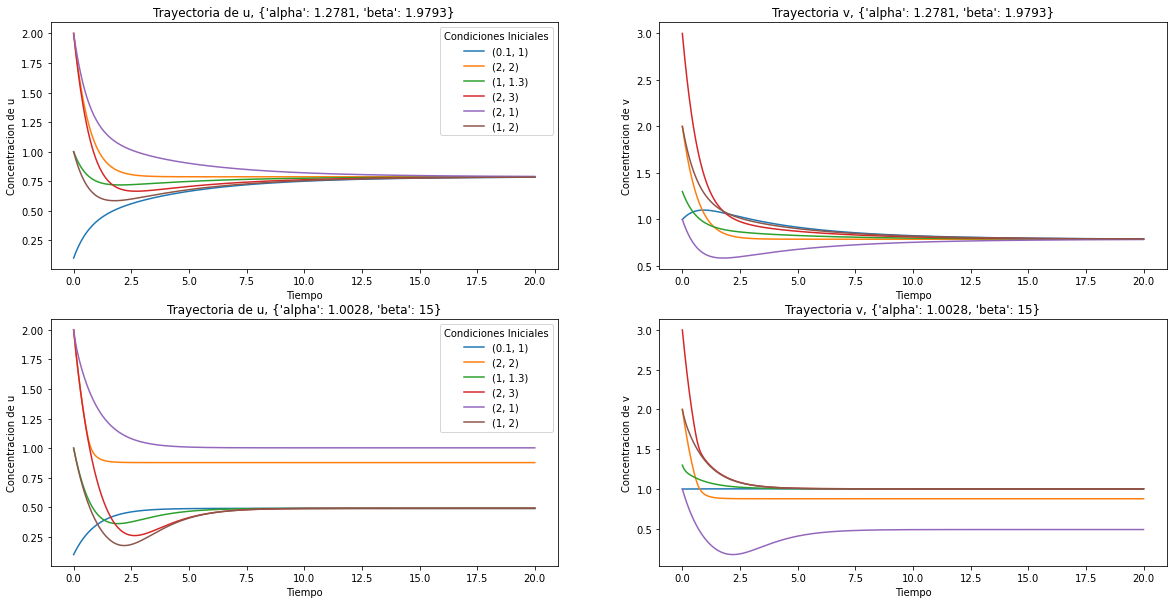

In [554]:
#Graficamos
fig_trayectorias, ax = plt.subplots(2,2,figsize=(20,10))
for i,param in enumerate(escenarios):
    for j,ic in enumerate(init_cond):
        ax[i][0].set(xlabel='Tiempo', ylabel='Concentracion de u', title='Trayectoria de u, {}'.format(param))
        ax[i][1].set(xlabel='Tiempo', ylabel='Concentracion de v', title='Trayectoria v, {}'.format(param))
        l = ax[i][0].plot(tiempo,trayectoria[i,j][:,0], label=ic)
        ax[i][1].plot(tiempo,trayectoria[i,j][:,1], color=l[0].get_color())
    ax[i][0].legend(title='Condiciones Iniciales')
plt.savefig("fig_trayectorias.png") # png


In [555]:
#Declaramos espacios para u y v
u_esp = np.linspace(0,2,100)
v_esp = np.linspace(0,2,100)

# Definimos funcion para graficar isoclinas
def plot_isoclinas(ax, u_esp, v_esp, alpha, beta, color='k', style='--', opacity=.5):
    ax.plot(u_esp, alpha/(1+u_esp**beta), style, color=color, alpha=opacity)
    ax.plot(alpha/(1+v_esp**beta),v_esp, style, color=color, alpha=opacity)
    ax.set(xlabel='u',ylabel='v')
    
# Definimos funcion para graficar el flujo

def plot_flujo(ax,param,u_esp,v_esp):
    X,Y = np.meshgrid(u_esp,v_esp)
    a = switch_celular([X,Y],0,**param)   
    ax.streamplot(X,Y,a[0,:,:], a[1,:,:], color=(0,0,0,.1))
    ax.set(xlim=(u_esp.min(),u_esp.max()), ylim=(v_esp.min(),v_esp.max()))
    
# Hallamos puntos de equilibrio
# Raices
def raices(f,init):
    sol, info, convergence, sms = scipy.optimize.fsolve(f, init, full_output=1)
    if convergence == 1:
        return sol
    return np.array([np.nan]*len(init))

# Puntos de Equilibrio
def equilibrios(flujo,puntos_init):
    equilibrios_aux = [] 
    raices_aux = [raices(flujo, init) 
             for init in puntos_init]
    # Nos quedamos con equilibrios unicos
    for r in raices_aux:
        if (not any(np.isnan(r)) and
            not any([all(np.isclose(r, x)) for x in equilibrios_aux])):
            equilibrios_aux.append(r)
    return equilibrios_aux

equilibrios_aux = {}

for i, param in enumerate(escenarios):
    # encontramos la posicion del equilibrio alrededor del punto final de cada trayectoria
    flujo = partial(switch_celular,t=0, **param)
    puntos_init = [trayectoria[i,j][-1,:] for j 
                       in range(len(init_cond))] 
    equilibrios_aux[i] = equilibrios(flujo, puntos_init)
    print('{} Punto(s) de Equilibrio para los parametros: {}'.format(len(equilibrios_aux[i]), param))





1 Punto(s) de Equilibrio para los parametros: {'alpha': 1.2781, 'beta': 1.9793}
3 Punto(s) de Equilibrio para los parametros: {'alpha': 1.0028, 'beta': 15}


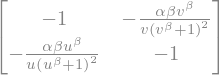

In [556]:
# Analisis de estabilidad de puntos de equilibrio(Localmente)
def jacobiano(u,v, alpha, beta):
    return - np.array([[1, alpha*beta*v**(beta-1) / (1+v**beta)**2  ],
                       [alpha*beta*u**(beta-1) / (1+u**beta)**2, 1]])

sympy.init_printing()

# Redefinimos variables para sympy
u, v = sympy.symbols("u, v")
alpha, beta = sympy.symbols("alpha, beta")

# Expresiones del sistema
dudt = alpha/(1 + v**beta) - u
dvdt = alpha/(1 + u**beta) - v

# Expresiones de la matriz 
sys = sympy.Matrix([dudt, dvdt])
var = sympy.Matrix([u, v])
jac = sys.jacobian(var)

# You can convert jac to a function:
jacobiano = sympy.lambdify((u, v, alpha, beta), jac, dummify=False)

jac

In [557]:
# Analisis de estabilidad
def estabilidad(jacobiana):
    determinante = np.linalg.det(jacobiana)
    traza = np.matrix.trace(jacobiana)
    if np.isclose(traza,0) and np.isclose(determinante,0):
        naturaleza = "Centro (Hopf)"
    elif np.isclose(determinante,0):
        naturaleza = "Silla-Nodo"
    elif determinante < 0:
        naturaleza = "Silla"
    else:
        naturaleza = "Estable" if traza < 0 else "Inestable"
        naturaleza += " Foco" if (traza**2 - 4 * determinante) < 0 else "Nodo" # Discriminante
    return naturaleza

# Auxiliar para llenado de naturaleza
estabilidad_eqs = {}

for i, param in enumerate(escenarios):
    print('\nParametros: {}'.format(param))
    estabilidad_eqs[i] = []
    for (u,v) in equilibrios_aux[i]:
        estabilidad_eqs[i].append(estabilidad(jacobiano(u,v, **param)))
        print("{} en ({} {})".format( estabilidad_eqs[i][-1], u,v,))


Parametros: {'alpha': 1.2781, 'beta': 1.9793}
EstableNodo en (0.7874320657327594 0.7874320657327591)

Parametros: {'alpha': 1.0028, 'beta': 15}
EstableNodo en (0.4909741379197763 1.0027767146117041)
Silla en (0.8780265332270382 0.8780265332270382)
EstableNodo en (1.0027767146117041 0.49097413791977584)


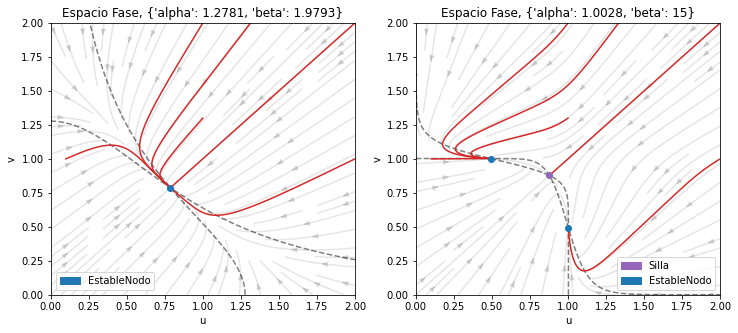

In [558]:
# Estetica de la grafica
EQ_COLOR = {'EstableNodo':'C0',
                    'InestableNodo':'C1', 
                    'Silla':'C4',
                    'EstableFoco':'C3',
                    'InestableFoco':'C2',
                    'Centro (Hopf)':'C5',
                    'Silla-Nodo':'C6'}
def plot_equilibrio(ax, posicion, naturaleza, legend=True):
    for pos, nat in zip(posicion,naturaleza):
        ax.scatter(pos[0],pos[1],
                   color= (EQ_COLOR[nat] 
                           if nat in EQ_COLOR
                           else 'k'),
                   zorder=100)
        
    if legend:
        # Etiquetas
        labels = list(frozenset(naturaleza))
        ax.legend([mpatches.Patch(color=EQ_COLOR[n]) for n in labels], labels)
        
fig_retrato_fase, ax = plt.subplots(1,2, figsize=(12,5))
for i, param in enumerate(escenarios):
    ax[i].set(xlabel='u', ylabel='v', title="Espacio Fase, {}".format(param))
    plot_flujo(ax[i], param, u_esp=u_esp, v_esp=v_esp)
    plot_isoclinas(ax[i], u_esp=u_esp, v_esp=v_esp, **param)
    for j in range(len(init_cond)):
        ax[i].plot(trayectoria[i,j][:,0],trayectoria[i,j][:,1], color='C3')
    plot_equilibrio(ax[i], equilibrios_aux[i], estabilidad_eqs[i])
    plt.savefig("fig__retrato_fase.png") # png


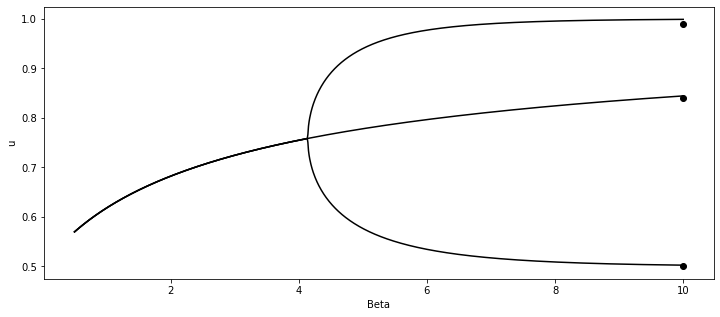

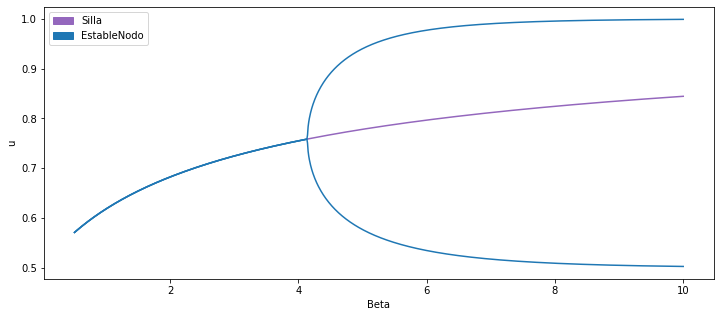

In [559]:
# Con el fin de hacer el diagrama de bifurcacoion en un parametro necesitamos encontrar las raices de la ecuacion no-lineal

espacio_beta = np.linspace(10,0.5,1000)
puntos_init = [(.5, .99), (0.84, .84), (.99, .5)]

def cont_numerica(f, initial_u, lbda_values):
    eq = []
    for lbda in lbda_values:
        eq.append(raices(lambda x: f(x,lbda),
                           eq[-1] if eq else initial_u))
    return eq

def func(u, lbda):
    return switch_celular(u, t=0, alpha=1., beta=lbda)

fig_diag_bifur0, ax = plt.subplots(1,1,figsize=(12,5))
ax.set(xlabel='Beta', ylabel='u')
for init in puntos_init:   
    # Puntos iniciales
    dots = plt.scatter(espacio_beta[0],init[0], color='k')
    
    # Continuacion Numerica
    eq = cont_numerica(func, np.array(init), espacio_beta)
    plt.plot(espacio_beta, [x[1] for x in eq], color='k')

def get_segments(values):
   
    start = 0
    segments = {}
    for i,val in enumerate(values[1:],1):
        if val != values[start] or i == len(values)-1:
            segments[(start,i)] = values[start]
            start = i
    return segments

def plot_bifurcacion(ax, ramas, espac_lbda):
    
    labels = frozenset()
    for eq, naturaleza in ramas:
        labels = labels.union(frozenset(naturaleza))
        segments = get_segments(naturaleza)
        for idx, n in segments.items():
            ax.plot(espac_lbda[idx[0]:idx[1]],eq[idx[0]:idx[1]],
                     color=EQ_COLOR[n] if n in EQ_COLOR else 'k')
    ax.legend([mpatches.Patch(color=EQ_COLOR[n]) for n in labels],
              labels)

def get_ramas(func, puntos_init, espac_lbda, jac):
    ramas = []
    for init in puntos_init:
        # Aplicamos continuacion numerica
        eq = cont_numerica(func, np.array(init), espac_lbda)
        naturaleza = [estabilidad(jac(u, lbda))
                  for (u, lbda) in zip(eq,espac_lbda)]
        ramas.append((np.array([x[0] for x in eq]),
                         naturaleza))
    return ramas

def func(u, lbda):
    return switch_celular(u, t=0, alpha=1., beta=lbda)
def jac(u, lbda):
    return jacobiano(u[0], u[1], alpha=1., beta=lbda)

ramas = get_ramas(func, puntos_init, espacio_beta, jac)

fig_diagBifur, ax = plt.subplots(1,1,figsize=(12,5))
plot_bifurcacion(ax, ramas, espacio_beta)
ax.set(xlabel='Beta', ylabel='u');
plt.savefig("fig_diagBifur.png")

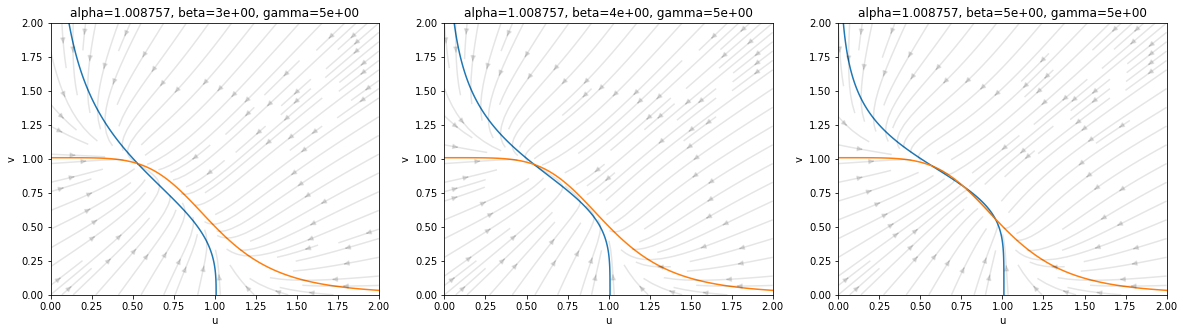

In [560]:
# En un solo parametro debemos descomponer la simetria del modelo
def switch_celular_asim(y,t,alpha, beta, gamma):
    u, v = y 
    return np.array([(alpha/(1+v**beta)) - u ,
                     (alpha/(1+u**gamma)) - v])
def jacobiano_asim(u,v, alpha, beta, gamma): 
    return - np.array([[1, alpha*beta*v**(beta-1) / (1+v**beta)**2],
                       [alpha*gamma*u**(gamma-1) / (1+u**gamma)**2, 1]])

# Fijamos los valores de gamma y de alpha
gamma= 4.897
alpha= 1.008757

beta_espacio = np.linspace(3,5,3)
beta_diag_espacio = np.linspace(7,0.5,1000)
puntos_init = [(0.5,1), (1,0.5), (0.75,0.75)]

fig_bifur1, axes = plt.subplots(1,3,figsize=(20,5))
for ax,beta in zip(axes,beta_espacio):
    ax.plot(alpha/(1+v_esp**beta),v_esp)
    ax.plot(u_esp, alpha/(1+u_esp**gamma))
    X,Y = np.meshgrid(u_esp,v_esp)
    a = switch_celular_asim([X,Y],t=0,alpha=alpha,beta=beta,gamma=gamma)   
    ax.streamplot(X,Y,a[0,:,:], a[1,:,:], color=(0,0,0,.1))
    ax.set(xlabel='u', ylabel='v', xlim=(0,2), ylim=(0,2),
                title='alpha={}, beta={:3.1}, gamma={:3.1}'.format(alpha,beta,gamma))
    plt.savefig("fig_bifur1.png")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


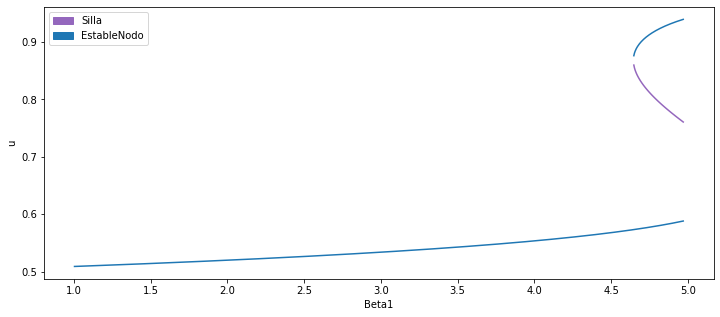

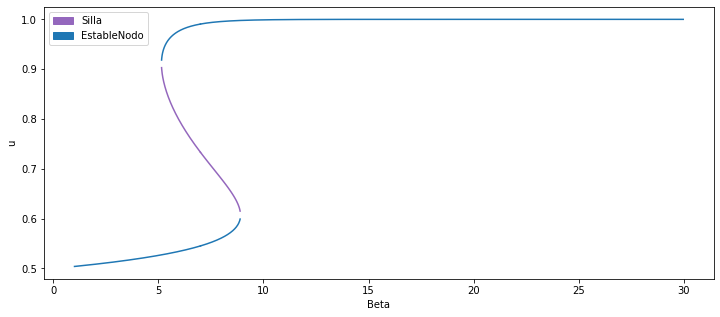

In [561]:
#Definimos nuevas funciones auxiliares
def func_asim(u, lbda):
    return switch_celular_asim(u, t=0, alpha=1., beta=lbda, gamma=gamma)
def jac_asim(u, lbda):
    return jacobiano_asim(u[0], u[1], alpha=1., beta=lbda, gamma=gamma)

beta_bdiag_espac = np.linspace(4.97,1,1000)
ramas = get_ramas(func_asim,puntos_init,beta_bdiag_espac,jac_asim)

fig_sillanodo, ax = plt.subplots(1,1,figsize=(12,5))
plot_bifurcacion(ax, ramas, beta_bdiag_espac)
ax.set(xlabel='Beta1', ylabel='u');
plt.savefig("fig_sillanodo.png")

# Fijamos los valores de gamma y de alpha
gamma= 6
alpha= 1

beta_bdiag_esp_izq = np.linspace(7,1,1000)
beta_bdiag_esp_der = np.linspace(7,30,1000)

ramas_izq = get_ramas(func_asim,puntos_init,beta_bdiag_esp_izq,jac_asim)
ramas_der = get_ramas(func_asim,puntos_init,beta_bdiag_esp_der,jac_asim)

fig_sillanodoA, ax = plt.subplots(1,1,figsize=(12,5))
plot_bifurcacion(ax, ramas_izq, beta_bdiag_esp_izq)
plot_bifurcacion(ax, ramas_der, beta_bdiag_esp_der)

ax.set(xlabel='Beta', ylabel='u');
plt.savefig("fig_sillanodoA.png")

In [562]:
#Espacio de parametros
p_espac = np.linspace(0, 13, 250)[1:]

variedad_equilibrios = defaultdict(lambda:[])

for i, beta in enumerate(p_espac):
    
    # Encontramos puntos iniciales.
    derivadas = partial(switch_celular_asim, alpha=1., beta=beta, gamma=beta)
    puntos_finales = []
    for j,ic in enumerate(init_cond):
        t = scipy.integrate.odeint(derivadas, 
                                   y0=ic, 
                                   t=np.linspace(0,1000,1000))
        puntos_finales.append(t[-1,:])
    puntos_init = equilibrios(partial(derivadas,t=0),
                                            puntos_finales)
    
    # Hacer continuacion numerica para cada punto inicial por la derecha y por la izquierda
    func = lambda u, lbda: switch_celular_asim(u,  t=0, alpha=1., beta=beta, gamma=lbda)  
    
    for continuacion_on in [p_espac[i:],p_espac[:i+1][::-1]]:
        for init in puntos_init:
            eq = cont_numerica(func, init, 
                                        continuacion_on)
            for gamma, pos in zip(continuacion_on,eq):
                if not any(np.isnan(pos)):
                    variedad_equilibrios[beta,gamma].append(pos)

/var/folders/4m/mmz7wfqx09746n0_0x5zb16r0000gn/T/ipykernel_78527/2051520499.py:4: RuntimeWarning: invalid value encountered in double_scalars
  return np.array([(alpha/(1+v**beta)) - u ,
/var/folders/4m/mmz7wfqx09746n0_0x5zb16r0000gn/T/ipykernel_78527/2051520499.py:5: RuntimeWarning: invalid value encountered in double_scalars
  (alpha/(1+u**gamma)) - v])


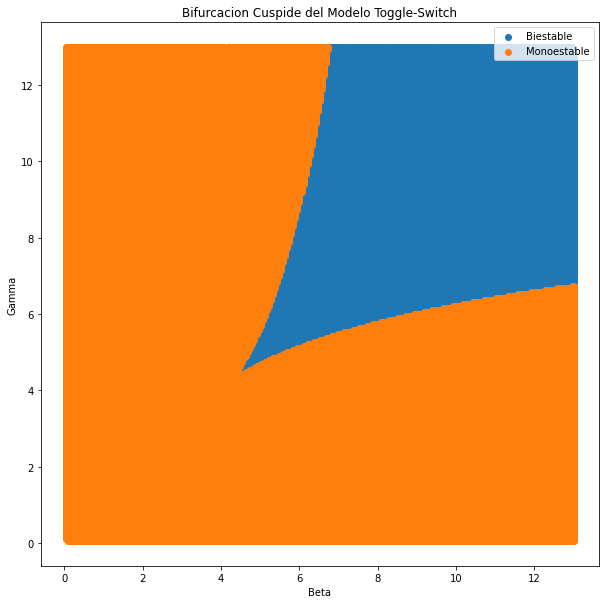

In [563]:
biestable = []
monoestable = []
for (beta,gamma),eq in variedad_equilibrios.items():
    if len(eq) == 3:
        biestable.append((beta,gamma))
    if len(eq) == 1:
        monoestable.append((beta,gamma))
        
fig_bifurCusp,ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(*zip(*biestable), label='Biestable')
ax.scatter(*zip(*monoestable), label='Monoestable')
ax.legend()
ax.set(xlabel='Beta',ylabel='Gamma', title='Bifurcacion Cuspide del Modelo Toggle-Switch');
plt.savefig("fig_bifurCusp.png")